In [95]:
%reload_ext autoreload
%autoreload 2

In [96]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

import torch.optim as optim
import torch
import torch.nn as nn

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display,clear_output

import warnings
warnings.filterwarnings("ignore")

In [97]:
from dataset import GermanCreditDataset
from experiments import Benchmarking
from utils.logger_config import setup_logger
from tqdm import tqdm
from models.wrapper import PYTORCH_MODELS

logger = setup_logger()

In [98]:
from experiments.counterfactual import *
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from models import PyTorchDNN, PyTorchLinearSVM, PyTorchRBFNet, PyTorchLogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.gaussian_process import GaussianProcessClassifier

dataset = GermanCreditDataset()
input_dim = dataset.get_dataframe().shape[1] - 1
seed = None
# torch.manual_seed(seed)

counterfactual_algorithms = [
    'DiCE',
    # 'DisCount',
    # 'GlobeCE'
    # 'AReS',
    # 'KNN',
]

experiment = Benchmarking(
    dataset=dataset,
    models=[
        # (GaussianProcessClassifier(),'sklearn'),
        # (PyTorchLogisticRegression(input_dim=input_dim), 'PYT'),
        (PyTorchDNN(input_dim=input_dim), 'PYT'),
        # (PyTorchRBFNet(input_dim=input_dim, hidden_dim=input_dim), 'PYT'),
        # (PyTorchLinearSVM(input_dim=input_dim), 'PYT'),
        # (RandomForestClassifier(n_estimators=10), 'sklearn'), 
        # (GradientBoostingClassifier(n_estimators=10), 'sklearn'), 
        # (AdaBoostClassifier(n_estimators=10), 'sklearn'), 
    ],
    shapley_methods=[
        # "Train_Distri",
        "CF_UniformMatch",
        # "CF_ExactMatch",
        "CF_SingleMatch",
        "CF_OTMatch",
        "CF_OTMatch_0.5", 
        "CF_OTMatch_1.0",
        # "CF_OTMatch_5.0",
        # "CF_OTMatch_10.0",
    ],
    distance_metrics=[
        'optimal_transport',
        'mean_difference',
        'median_difference',
        # 'max_mean_discrepancy',
    ]
)

experiment.train_and_evaluate_models(random_state=seed)
experiment.models_performance()

logger.info("\n\n------Compute Counterfactuals------")
sample_num = 50
model_counterfactuals = {}
for model, model_name in zip(experiment.models, experiment.model_names):
    model_counterfactuals[model_name] = {}

    for algorithm in counterfactual_algorithms:
        if algorithm == 'DisCount' and model_name not in PYTORCH_MODELS:
            logger.info(f'Skipping {algorithm} for {model_name} due to incompatability')
            continue
        logger.info(f'Computing {model_name} counterfactuals with {algorithm}')
        function_name = f"compute_{algorithm}_counterfactuals"
        try:
            func = globals()[function_name]
            model_counterfactuals[model_name][algorithm] = func(
                experiment.X_test,
                model = model,
                target_name = experiment.dataset.target_name,
                sample_num = sample_num,
                experiment=experiment,
            )
        except KeyError:
            print(f"Function {function_name} is not defined.")


INFO:root:PyTorchDNN accuracy: 0.6866666666666666
INFO:root:

------Compute Counterfactuals------
INFO:root:Computing PyTorchDNN counterfactuals with DiCE
100%|██████████| 50/50 [09:22<00:00, 11.25s/it]


In [99]:
logger.info("\n\n------Compute Shapley Values------")
experiment.compute_shapley_values(
    model_counterfactuals=model_counterfactuals,
);

INFO:root:

------Compute Shapley Values------
INFO:root:Shapley values for PyTorchDNN using CF_UniformMatch with counterfactual by DiCE


  0%|          | 0/50 [00:00<?, ?it/s]

INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([ 0.26799779,  0.13701251,  0.14179242,  0.20299441, -0.02152864,
       -0.13360258,  0.02317151,  0.15101158,  0.03475669])
INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([ 0.06774951, -0.04625545,  0.01570447,  0.35666878,  0.05300588,
        0.01559606,  0.03257613,  0.33605055,  0.03861042])
INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([ 0.22247416,  0.09265216,  0.13166027,  0.01631043,  0.04931365,
        0.18340239, -0.07228527,  0.20884365,  0.0375383 ])
INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([ 0.0381468 , -0.1698918 ,  0.06728555,  0.04482916,  0.05832094,
        0.02031138,  0.13692363, -0.2459072 , -0.06692307])
INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([0.14617399, 0.03839602, 0.13382091, 0.10324593, 0.06768272,
       0.15090098, 0.00652679, 0.19488223, 0.02558233])
INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([ 0.02811765,  0.07551611,  0.21806124,  0.06381364,  0.07608

In [107]:
logger.info("\n\n------Evaluating Distance Performance Under Interventions------")
experiment.evaluate_distance_performance_under_interventions(
    intervention_num_list=[0, 50, 100, 150, 200, 250, 300, 400],
    trials_num=10,
    replace=False
)

INFO:root:

------Evaluating Distance Performance Under Interventions------
INFO:root:Computing optimal_transport for (PyTorchDNN, DiCE, CF_UniformMatch)
100%|██████████| 10/10 [00:00<00:00, 13.99it/s]
INFO:root:Computing mean_difference for (PyTorchDNN, DiCE, CF_UniformMatch)
100%|██████████| 10/10 [00:00<00:00, 31.03it/s]
INFO:root:Computing median_difference for (PyTorchDNN, DiCE, CF_UniformMatch)
100%|██████████| 10/10 [00:00<00:00, 71.08it/s]
INFO:root:Computing optimal_transport for (PyTorchDNN, DiCE, CF_SingleMatch)
100%|██████████| 10/10 [00:00<00:00, 30.80it/s]
INFO:root:Computing mean_difference for (PyTorchDNN, DiCE, CF_SingleMatch)
100%|██████████| 10/10 [00:00<00:00, 50.61it/s]
INFO:root:Computing median_difference for (PyTorchDNN, DiCE, CF_SingleMatch)
100%|██████████| 10/10 [00:00<00:00, 62.99it/s]
INFO:root:Computing optimal_transport for (PyTorchDNN, DiCE, CF_OTMatch)
100%|██████████| 10/10 [00:00<00:00, 22.13it/s]
INFO:root:Computing mean_difference for (PyTorchDNN, D

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]


INFO:gurobipy:CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 53 rows, 25601 columns and 73680 nonzeros


INFO:gurobipy:Optimize a model with 53 rows, 25601 columns and 73680 nonzeros


Model fingerprint: 0xc8d8681d


INFO:gurobipy:Model fingerprint: 0xc8d8681d


Variable types: 1 continuous, 25600 integer (25600 binary)


INFO:gurobipy:Variable types: 1 continuous, 25600 integer (25600 binary)


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [2e-02, 9e+00]


INFO:gurobipy:  Matrix range     [2e-02, 9e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 1e+00]


INFO:gurobipy:  RHS range        [1e+00, 1e+00]


Found heuristic solution: objective 0.8599999


INFO:gurobipy:Found heuristic solution: objective 0.8599999


Presolve removed 53 rows and 25601 columns


INFO:gurobipy:Presolve removed 53 rows and 25601 columns


Presolve time: 0.05s


INFO:gurobipy:Presolve time: 0.05s


Presolve: All rows and columns removed


INFO:gurobipy:Presolve: All rows and columns removed


INFO:gurobipy:


Explored 0 nodes (0 simplex iterations) in 0.18 seconds (0.01 work units)


INFO:gurobipy:Explored 0 nodes (0 simplex iterations) in 0.18 seconds (0.01 work units)


Thread count was 1 (of 8 available processors)


INFO:gurobipy:Thread count was 1 (of 8 available processors)


INFO:gurobipy:


Solution count 1: 0.86 


INFO:gurobipy:Solution count 1: 0.86 


INFO:gurobipy:


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Best objective 8.599998950958e-01, best bound 8.599998950958e-01, gap 0.0000%


INFO:gurobipy:Best objective 8.599998950958e-01, best bound 8.599998950958e-01, gap 0.0000%
 12%|█▎        | 1/8 [00:20<02:26, 20.89s/it]

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]


INFO:gurobipy:CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 53 rows, 25601 columns and 73680 nonzeros


INFO:gurobipy:Optimize a model with 53 rows, 25601 columns and 73680 nonzeros


Model fingerprint: 0xfcda366a


INFO:gurobipy:Model fingerprint: 0xfcda366a


Variable types: 1 continuous, 25600 integer (25600 binary)


INFO:gurobipy:Variable types: 1 continuous, 25600 integer (25600 binary)


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [2e-02, 9e+00]


INFO:gurobipy:  Matrix range     [2e-02, 9e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 5e+01]


INFO:gurobipy:  RHS range        [1e+00, 5e+01]


Found heuristic solution: objective 0.7600000


INFO:gurobipy:Found heuristic solution: objective 0.7600000


Presolve removed 53 rows and 25601 columns


INFO:gurobipy:Presolve removed 53 rows and 25601 columns


Presolve time: 0.06s


INFO:gurobipy:Presolve time: 0.06s


Presolve: All rows and columns removed


INFO:gurobipy:Presolve: All rows and columns removed


INFO:gurobipy:


Explored 0 nodes (0 simplex iterations) in 0.15 seconds (0.02 work units)


INFO:gurobipy:Explored 0 nodes (0 simplex iterations) in 0.15 seconds (0.02 work units)


Thread count was 1 (of 8 available processors)


INFO:gurobipy:Thread count was 1 (of 8 available processors)


INFO:gurobipy:


Solution count 2: 0 0.76 


INFO:gurobipy:Solution count 2: 0 0.76 


INFO:gurobipy:


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%


INFO:gurobipy:Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
 25%|██▌       | 2/8 [00:41<02:04, 20.70s/it]

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]


INFO:gurobipy:CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 53 rows, 25601 columns and 73680 nonzeros


INFO:gurobipy:Optimize a model with 53 rows, 25601 columns and 73680 nonzeros


Model fingerprint: 0xd87c8bb4


INFO:gurobipy:Model fingerprint: 0xd87c8bb4


Variable types: 1 continuous, 25600 integer (25600 binary)


INFO:gurobipy:Variable types: 1 continuous, 25600 integer (25600 binary)


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [2e-02, 9e+00]


INFO:gurobipy:  Matrix range     [2e-02, 9e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 1e+02]


INFO:gurobipy:  RHS range        [1e+00, 1e+02]


Found heuristic solution: objective 0.6199999


INFO:gurobipy:Found heuristic solution: objective 0.6199999


Presolve removed 53 rows and 25601 columns


INFO:gurobipy:Presolve removed 53 rows and 25601 columns


Presolve time: 0.05s


INFO:gurobipy:Presolve time: 0.05s


Presolve: All rows and columns removed


INFO:gurobipy:Presolve: All rows and columns removed


INFO:gurobipy:


Explored 0 nodes (0 simplex iterations) in 0.12 seconds (0.02 work units)


INFO:gurobipy:Explored 0 nodes (0 simplex iterations) in 0.12 seconds (0.02 work units)


Thread count was 1 (of 8 available processors)


INFO:gurobipy:Thread count was 1 (of 8 available processors)


INFO:gurobipy:


Solution count 2: 0 0.62 


INFO:gurobipy:Solution count 2: 0 0.62 


INFO:gurobipy:


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%


INFO:gurobipy:Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
 38%|███▊      | 3/8 [00:58<01:35, 19.15s/it]

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]


INFO:gurobipy:CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 53 rows, 25601 columns and 73680 nonzeros


INFO:gurobipy:Optimize a model with 53 rows, 25601 columns and 73680 nonzeros


Model fingerprint: 0x94477460


INFO:gurobipy:Model fingerprint: 0x94477460


Variable types: 1 continuous, 25600 integer (25600 binary)


INFO:gurobipy:Variable types: 1 continuous, 25600 integer (25600 binary)


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [2e-02, 9e+00]


INFO:gurobipy:  Matrix range     [2e-02, 9e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 2e+02]


INFO:gurobipy:  RHS range        [1e+00, 2e+02]


Found heuristic solution: objective 0.5200000


INFO:gurobipy:Found heuristic solution: objective 0.5200000


Presolve removed 53 rows and 25601 columns


INFO:gurobipy:Presolve removed 53 rows and 25601 columns


Presolve time: 0.13s


INFO:gurobipy:Presolve time: 0.13s


Presolve: All rows and columns removed


INFO:gurobipy:Presolve: All rows and columns removed


INFO:gurobipy:


Explored 0 nodes (0 simplex iterations) in 0.24 seconds (0.02 work units)


INFO:gurobipy:Explored 0 nodes (0 simplex iterations) in 0.24 seconds (0.02 work units)


Thread count was 1 (of 8 available processors)


INFO:gurobipy:Thread count was 1 (of 8 available processors)


INFO:gurobipy:


Solution count 2: 0 0.52 


INFO:gurobipy:Solution count 2: 0 0.52 


INFO:gurobipy:


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%


INFO:gurobipy:Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
 50%|█████     | 4/8 [01:29<01:34, 23.71s/it]

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]


INFO:gurobipy:CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 53 rows, 25601 columns and 73680 nonzeros


INFO:gurobipy:Optimize a model with 53 rows, 25601 columns and 73680 nonzeros


Model fingerprint: 0x37672da0


INFO:gurobipy:Model fingerprint: 0x37672da0


Variable types: 1 continuous, 25600 integer (25600 binary)


INFO:gurobipy:Variable types: 1 continuous, 25600 integer (25600 binary)


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [2e-02, 9e+00]


INFO:gurobipy:  Matrix range     [2e-02, 9e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 2e+02]


INFO:gurobipy:  RHS range        [1e+00, 2e+02]


Found heuristic solution: objective 0.4000001


INFO:gurobipy:Found heuristic solution: objective 0.4000001


Presolve removed 53 rows and 25601 columns


INFO:gurobipy:Presolve removed 53 rows and 25601 columns


Presolve time: 0.10s


INFO:gurobipy:Presolve time: 0.10s


Presolve: All rows and columns removed


INFO:gurobipy:Presolve: All rows and columns removed


INFO:gurobipy:


Explored 0 nodes (0 simplex iterations) in 0.24 seconds (0.02 work units)


INFO:gurobipy:Explored 0 nodes (0 simplex iterations) in 0.24 seconds (0.02 work units)


Thread count was 1 (of 8 available processors)


INFO:gurobipy:Thread count was 1 (of 8 available processors)


INFO:gurobipy:


Solution count 2: 0 0.4 


INFO:gurobipy:Solution count 2: 0 0.4 


INFO:gurobipy:


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%


INFO:gurobipy:Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
 62%|██████▎   | 5/8 [02:08<01:28, 29.39s/it]

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]


INFO:gurobipy:CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 53 rows, 25601 columns and 73680 nonzeros


INFO:gurobipy:Optimize a model with 53 rows, 25601 columns and 73680 nonzeros


Model fingerprint: 0xdc227daa


INFO:gurobipy:Model fingerprint: 0xdc227daa


Variable types: 1 continuous, 25600 integer (25600 binary)


INFO:gurobipy:Variable types: 1 continuous, 25600 integer (25600 binary)


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [2e-02, 9e+00]


INFO:gurobipy:  Matrix range     [2e-02, 9e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 3e+02]


INFO:gurobipy:  RHS range        [1e+00, 3e+02]


Found heuristic solution: objective 0.4000001


INFO:gurobipy:Found heuristic solution: objective 0.4000001


Presolve removed 53 rows and 25601 columns


INFO:gurobipy:Presolve removed 53 rows and 25601 columns


Presolve time: 0.12s


INFO:gurobipy:Presolve time: 0.12s


Presolve: All rows and columns removed


INFO:gurobipy:Presolve: All rows and columns removed


INFO:gurobipy:


Explored 0 nodes (0 simplex iterations) in 0.22 seconds (0.02 work units)


INFO:gurobipy:Explored 0 nodes (0 simplex iterations) in 0.22 seconds (0.02 work units)


Thread count was 1 (of 8 available processors)


INFO:gurobipy:Thread count was 1 (of 8 available processors)


INFO:gurobipy:


Solution count 2: 0 0.4 


INFO:gurobipy:Solution count 2: 0 0.4 


INFO:gurobipy:


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%


INFO:gurobipy:Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
 75%|███████▌  | 6/8 [02:33<00:55, 27.81s/it]

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]


INFO:gurobipy:CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 53 rows, 25601 columns and 73680 nonzeros


INFO:gurobipy:Optimize a model with 53 rows, 25601 columns and 73680 nonzeros


Model fingerprint: 0xf1eb2bab


INFO:gurobipy:Model fingerprint: 0xf1eb2bab


Variable types: 1 continuous, 25600 integer (25600 binary)


INFO:gurobipy:Variable types: 1 continuous, 25600 integer (25600 binary)


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [2e-02, 9e+00]


INFO:gurobipy:  Matrix range     [2e-02, 9e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 3e+02]


INFO:gurobipy:  RHS range        [1e+00, 3e+02]


Found heuristic solution: objective 0.4000001


INFO:gurobipy:Found heuristic solution: objective 0.4000001


Presolve removed 53 rows and 25601 columns


INFO:gurobipy:Presolve removed 53 rows and 25601 columns


Presolve time: 0.09s


INFO:gurobipy:Presolve time: 0.09s


Presolve: All rows and columns removed


INFO:gurobipy:Presolve: All rows and columns removed


INFO:gurobipy:


Explored 0 nodes (0 simplex iterations) in 0.19 seconds (0.02 work units)


INFO:gurobipy:Explored 0 nodes (0 simplex iterations) in 0.19 seconds (0.02 work units)


Thread count was 1 (of 8 available processors)


INFO:gurobipy:Thread count was 1 (of 8 available processors)


INFO:gurobipy:


Solution count 2: 0 0.4 


INFO:gurobipy:Solution count 2: 0 0.4 


INFO:gurobipy:


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%


INFO:gurobipy:Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
 88%|████████▊ | 7/8 [03:02<00:28, 28.13s/it]

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]


INFO:gurobipy:CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 53 rows, 25601 columns and 73680 nonzeros


INFO:gurobipy:Optimize a model with 53 rows, 25601 columns and 73680 nonzeros


Model fingerprint: 0x53b46e9f


INFO:gurobipy:Model fingerprint: 0x53b46e9f


Variable types: 1 continuous, 25600 integer (25600 binary)


INFO:gurobipy:Variable types: 1 continuous, 25600 integer (25600 binary)


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [2e-02, 9e+00]


INFO:gurobipy:  Matrix range     [2e-02, 9e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


INFO:gurobipy:  RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 0.4000001


INFO:gurobipy:Found heuristic solution: objective 0.4000001


Presolve removed 53 rows and 25601 columns


INFO:gurobipy:Presolve removed 53 rows and 25601 columns


Presolve time: 0.05s


INFO:gurobipy:Presolve time: 0.05s


Presolve: All rows and columns removed


INFO:gurobipy:Presolve: All rows and columns removed


INFO:gurobipy:


Explored 0 nodes (0 simplex iterations) in 0.13 seconds (0.02 work units)


INFO:gurobipy:Explored 0 nodes (0 simplex iterations) in 0.13 seconds (0.02 work units)


Thread count was 1 (of 8 available processors)


INFO:gurobipy:Thread count was 1 (of 8 available processors)


INFO:gurobipy:


Solution count 2: 0 0.4 


INFO:gurobipy:Solution count 2: 0 0.4 


INFO:gurobipy:


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%


INFO:gurobipy:Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
100%|██████████| 8/8 [03:31<00:00, 26.44s/it]


In [103]:
# from copy import deepcopy
# distance_results_backup = deepcopy(experiment.distance_results)

In [104]:
# import pickle 
# with open(f"pickles/{dataset.name}_distance_results.pickle", "rb") as input_file:
#     experiment.distance_results.update(pickle.load(input_file))

In [108]:
experiment.distance_results['PyTorchDNN']['DiCE']

{'CF_UniformMatch': {'optimal_transport': [{'x_list': [0,
     50,
     100,
     150,
     200,
     250,
     300,
     400],
    'y_list': [0.5225662362467602,
     0.37375972838473276,
     0.269750885128978,
     0.23705408024250532,
     0.11350295939730642,
     0.059695964631162494,
     0.045258819733917925,
     5.390204122309505e-05]},
   {'x_list': [0, 50, 100, 150, 200, 250, 300, 400],
    'y_list': [0.5225662362467602,
     0.37045816581990554,
     0.302931624692789,
     0.22383807597077862,
     0.194983198207144,
     0.05554756450167701,
     0.02454735062857298,
     0.0005862698893801177]},
   {'x_list': [0, 50, 100, 150, 200, 250, 300, 400],
    'y_list': [0.5225662362467602,
     0.37371229687412155,
     0.24731222734152156,
     0.2311240833945027,
     0.1058136392418926,
     0.09950386739263525,
     0.03473502220090782,
     1.821757973256233e-05]},
   {'x_list': [0, 50, 100, 150, 200, 250, 300, 400],
    'y_list': [0.5225662362467602,
     0.34681915208677

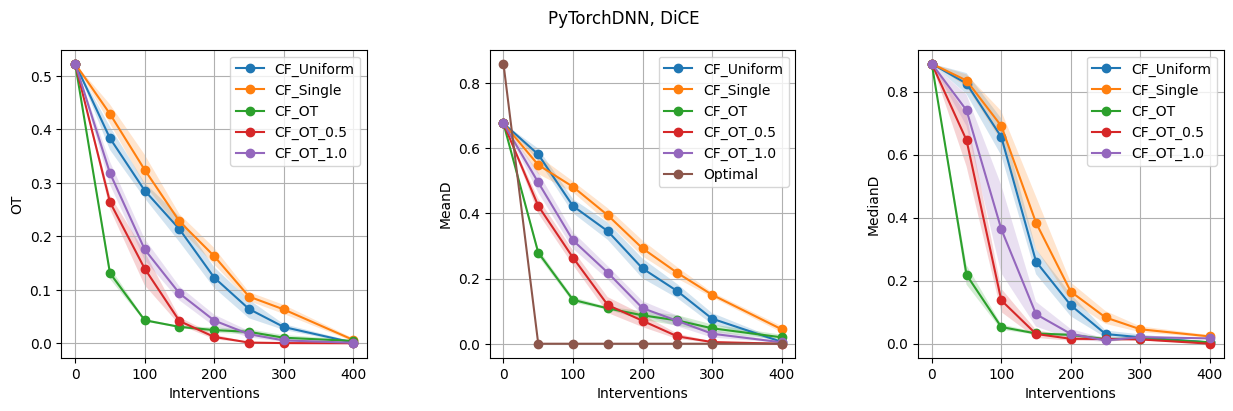

In [129]:
from experiments import plotting

plotting.intervention_vs_distance(experiment, save_to_file=False)

In [ ]:
# import pickle
# with open(f"pickles/{dataset.name}_distance_results.pickle", "wb") as output_file:
#     pickle.dump(experiment.distance_results, output_file)

In [131]:
from experiments.baseline import OptimalMeanDifference

In [132]:
model_name = model.classifier.__class__.__name__

In [133]:
X_factual = model_counterfactuals[model_name]['DiCE']['X_factual']
X_counterfactual = model_counterfactuals[model_name]['DiCE']['X']

In [134]:
optimal_mean_difference = OptimalMeanDifference(model, X_factual, X_counterfactual)

In [135]:
optimal_mean_difference.solve_problem(C=0)

{'eta': 0.6767136536841278}